In [1]:
library(foreign)
library(ggplot2)
library(VGAM)
library(boot)

Loading required package: stats4
Loading required package: splines

Attaching package: 'boot'

The following objects are masked from 'package:VGAM':

    logit, simplex



### Examples of zero-truncated Poisson regression

### Description of the data

In [2]:
dat <- read.dta("./datasets/ztp.dta")

dat <- within(dat, {
    hmo <- factor(hmo)
    died <- factor(died) })

summary(dat)

      stay             age        hmo      died   
 Min.   : 1.000   Min.   :1.000   0:1254   0:981  
 1st Qu.: 4.000   1st Qu.:4.000   1: 239   1:512  
 Median : 8.000   Median :5.000                   
 Mean   : 9.729   Mean   :5.234                   
 3rd Qu.:13.000   3rd Qu.:6.000                   
 Max.   :74.000   Max.   :9.000                   

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


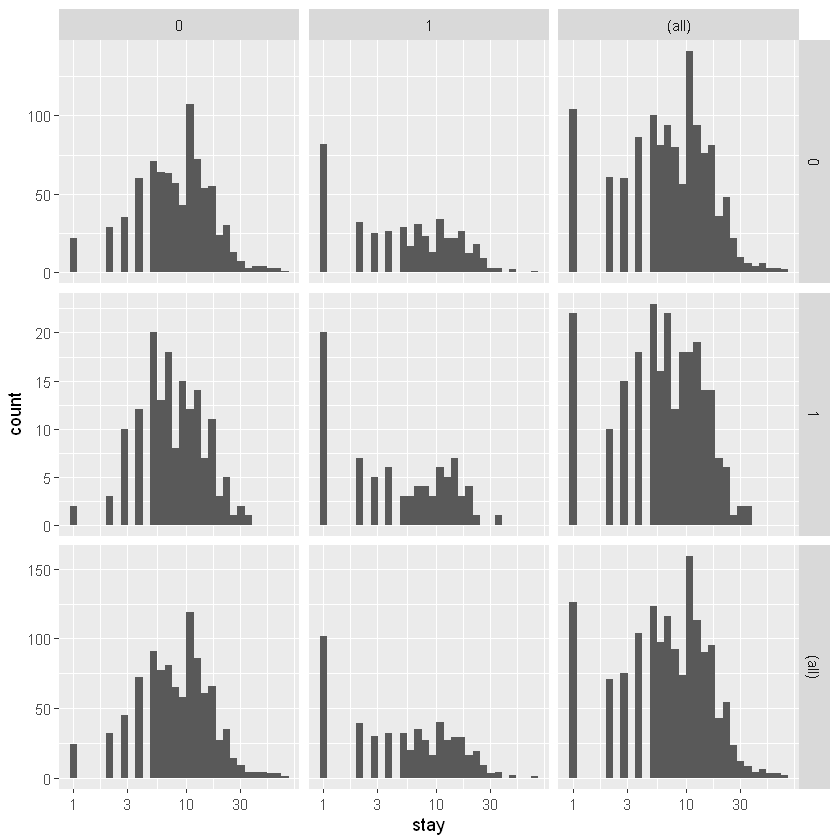

In [3]:
ggplot(dat, aes(stay)) +
  geom_histogram() + scale_x_log10() + facet_grid(hmo ~ died, margins=TRUE, scales="free_y")

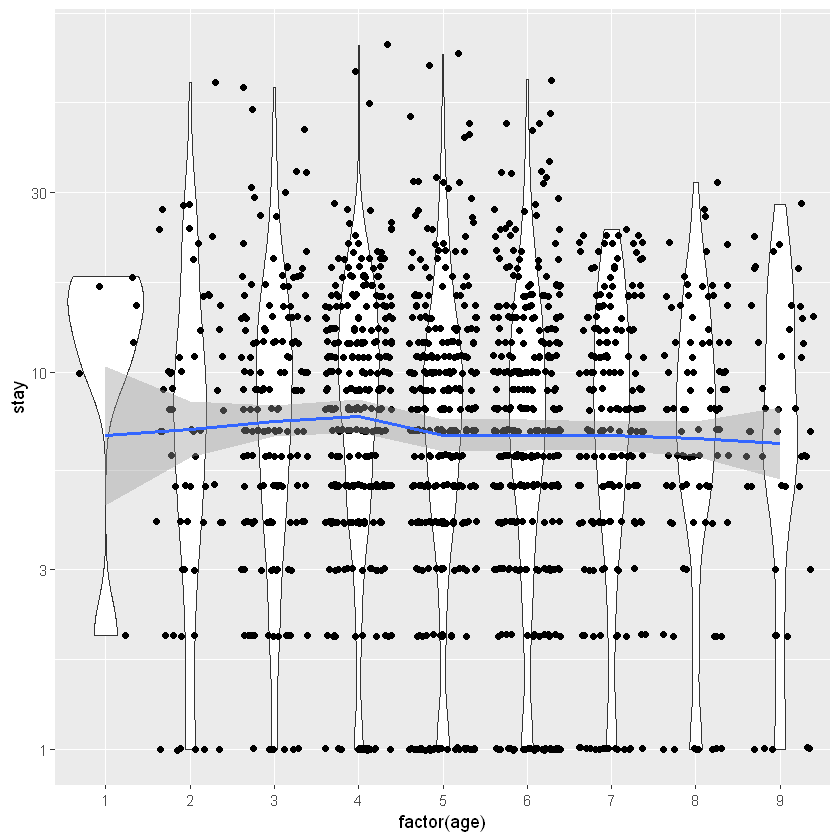

In [4]:
ggplot(dat, aes(factor(age), stay)) +
  geom_violin() + geom_jitter(size=1.5) + scale_y_log10() + stat_smooth(aes(x = age, y = stay, group=1), method="loess")

Warning message:
"Removed 50 rows containing missing values (geom_bar)."

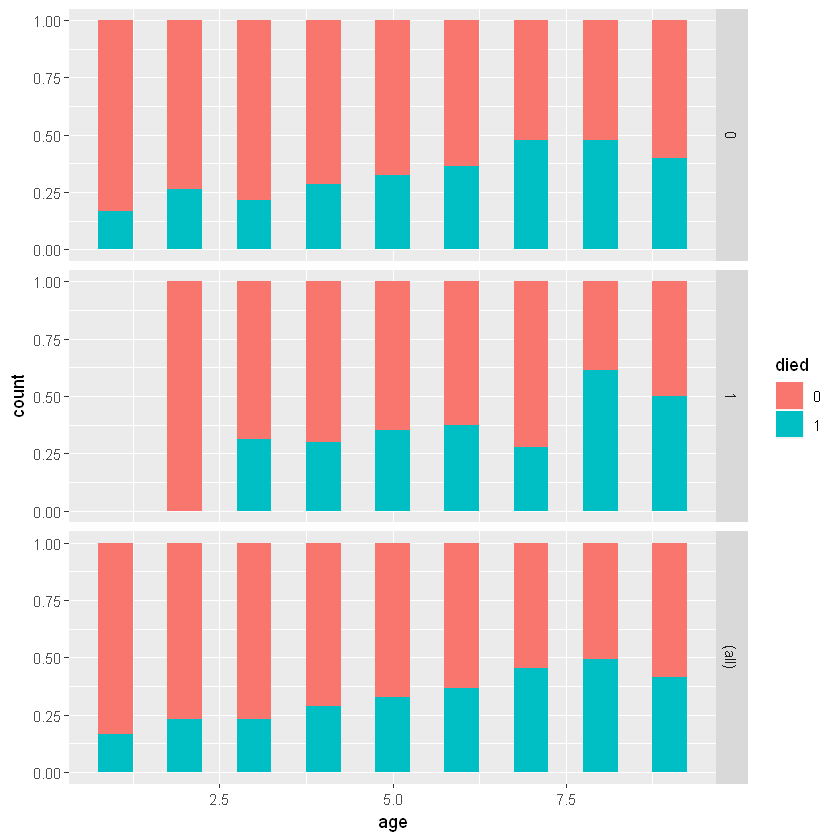

In [5]:
ggplot(dat, aes(age, fill=died)) +
  geom_histogram(binwidth=.5, position="fill") + facet_grid(hmo ~ ., margins=TRUE)

### Analysis methods you might consider

### Zero-truncated Poisson regression

In [6]:
m1 <- vglm(stay ~ age + hmo + died, family = pospoisson(), data = dat)
summary(m1) 


Call:
vglm(formula = stay ~ age + hmo + died, family = pospoisson(), 
    data = dat)

Pearson residuals:
                   Min     1Q  Median     3Q   Max
loglink(lambda) -3.032 -1.727 -0.5868 0.9794 20.84

Coefficients: 
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.435808   0.027332  89.119  < 2e-16 ***
age         -0.014442   0.005035  -2.869  0.00412 ** 
hmo1        -0.135903   0.023741  -5.724 1.04e-08 ***
died1       -0.203771   0.018372 -11.091  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Name of linear predictor: loglink(lambda) 

Log-likelihood: -6908.799 on 1489 degrees of freedom

Number of Fisher scoring iterations: 3 

No Hauck-Donner effect found in any of the estimates


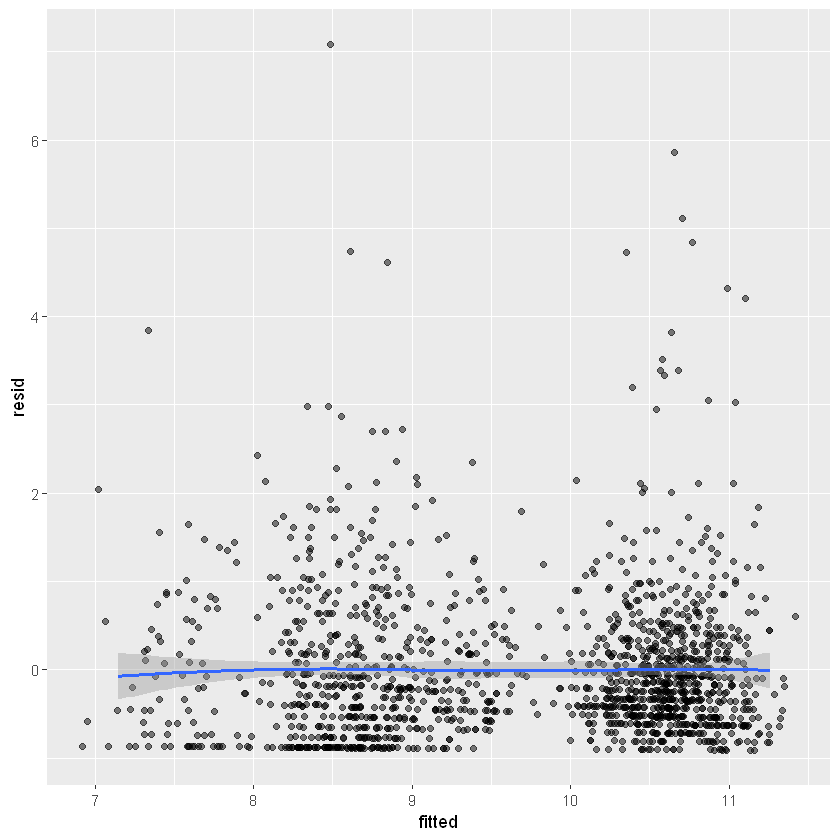

In [7]:
output <- data.frame(resid = resid(m1), fitted = fitted(m1))
ggplot(output, aes(fitted, resid)) +
  geom_jitter(position=position_jitter(width=.25), alpha=.5) + stat_smooth(method="loess")

Smoothing formula not specified. Using: y ~ x


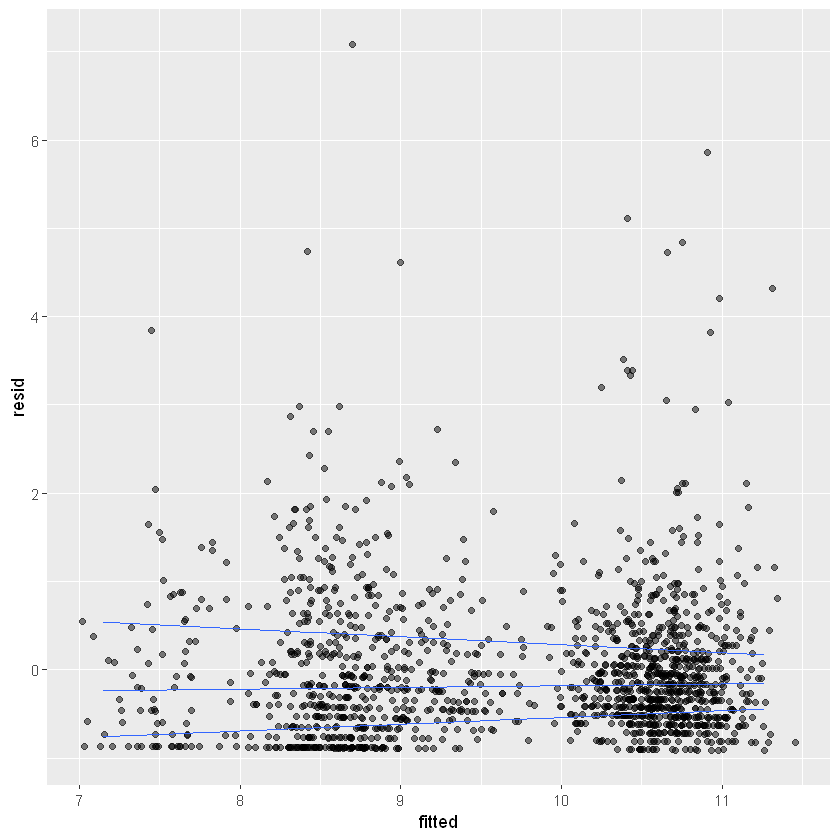

In [8]:
ggplot(output, aes(fitted, resid)) +
  geom_jitter(position=position_jitter(width=.25), alpha=.5) +  stat_quantile(method="rq")

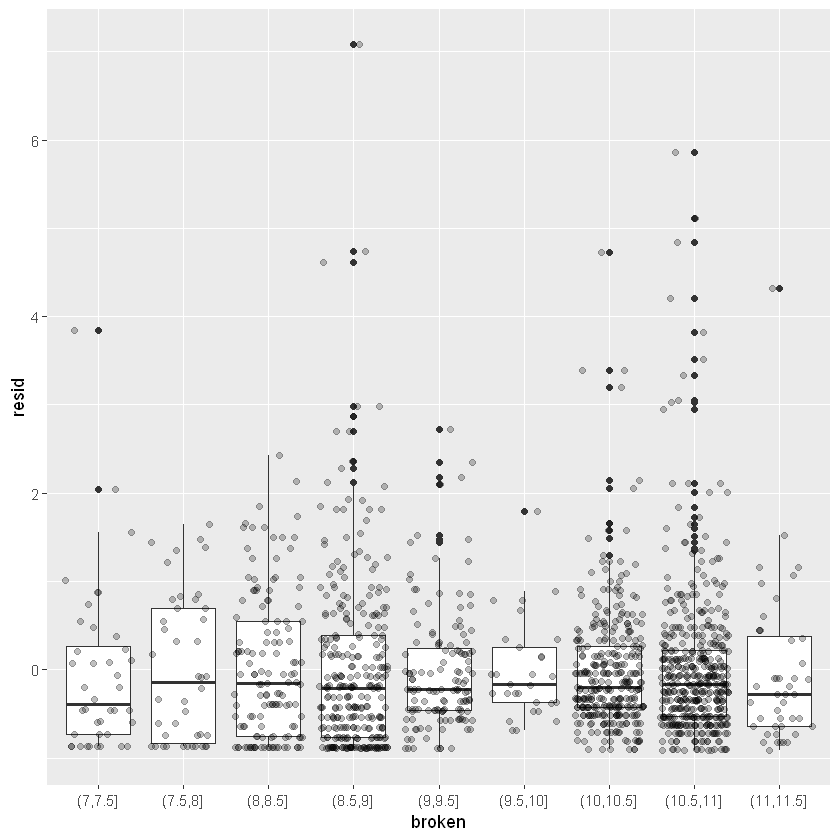

In [9]:
output <- within(output, {
  broken <- cut(fitted, hist(fitted, plot=FALSE)$breaks) })

ggplot(output, aes(broken, resid)) + geom_boxplot() + geom_jitter(alpha=.25)

In [10]:
dput(round(coef(m1),3))

c(`(Intercept)` = 2.436, age = -0.014, hmo1 = -0.136, died1 = -0.204
)


In [11]:
f <- function(data, i) {
  require(VGAM)
  m <- vglm(formula = stay ~ age + hmo + died, family = pospoisson(),
    data = data[i, ], coefstart = c(2.436, -0.014, -0.136, -0.204))
  as.vector(t(coef(summary(m))[, 1:2])) }

set.seed(10)
res <- boot(dat, f, R = 1200, parallel = "snow", ncpus = 4)

## print results
res


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = dat, statistic = f, R = 1200, parallel = "snow", 
    ncpus = 4)


Bootstrap Statistics :
       original        bias     std. error
t1*  2.43580824  1.353730e-03 0.0715294961
t2*  0.02733232  1.717131e-05 0.0005644024
t3* -0.01444203 -3.347447e-04 0.0122267387
t4*  0.00503471  4.363739e-06 0.0001001218
t5* -0.13590330 -2.166791e-04 0.0519484266
t6*  0.02374183  6.587369e-05 0.0007743846
t7* -0.20377089 -3.539929e-04 0.0485653166
t8*  0.01837281  3.137670e-05 0.0003451768

In [12]:
## basic parameter estimates with percentile and bias adjusted CIs
parms <- t(sapply(c(1, 3, 5, 7), function(i) {
  out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "basic"))
  with(out, c(Est = t0, pLL = percent[4], pUL = percent[5],
    basicLL = basic[4], basicLL = basic[5]))  }))

## add row names
row.names(parms) <- names(coef(m1))
## print results
parms

,Est,pLL,pUL,basicLL,basicLL
(Intercept),2.43580824,2.29847349,2.582309282,2.28930719,2.57314298
age,-0.01444203,-0.03955533,0.009766209,-0.03865026,0.01067128
hmo1,-0.13590330,-0.23858984,-0.034864002,-0.23694259,-0.03321675
died1,-0.20377089,-0.29684126,-0.112926767,-0.29461502,-0.11070052


In [13]:
## exponentiated parameter estimates with percentile and bias adjusted CIs
expparms <- t(sapply(c(1, 3, 5, 7), function(i) {
  out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "basic"), h = exp)
  with(out, c(Est = t0, pLL = percent[4], pUL = percent[5],
    basicLL = basic[4], basicLL = basic[5]))  }))

## add row names
row.names(expparms) <- names(coef(m1))
## print results
expparms

,Est,pLL,pUL,basicLL,basicLL
(Intercept),11.4250491,9.9589684,13.2276493,9.6224489,12.8911299
age,0.9856618,0.9612168,1.0098141,0.9615095,1.0101068
hmo1,0.8729270,0.7877379,0.9657367,0.7801173,0.9581162
died1,0.8156492,0.7431620,0.8932161,0.7380824,0.8881365


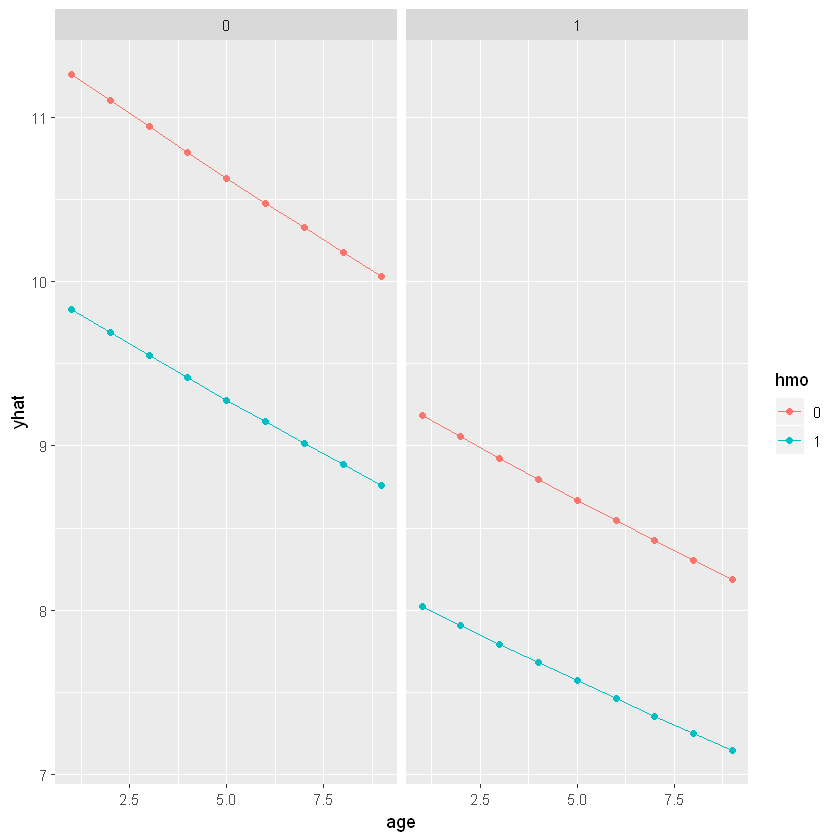

In [14]:
newdata <- expand.grid(age = 1:9, hmo = factor(0:1), died = factor(0:1))
newdata$yhat <- predict(m1, newdata, type = "response")

ggplot(newdata, aes(x = age, y = yhat, colour = hmo)) + geom_point() + geom_line() + facet_wrap(~ died)

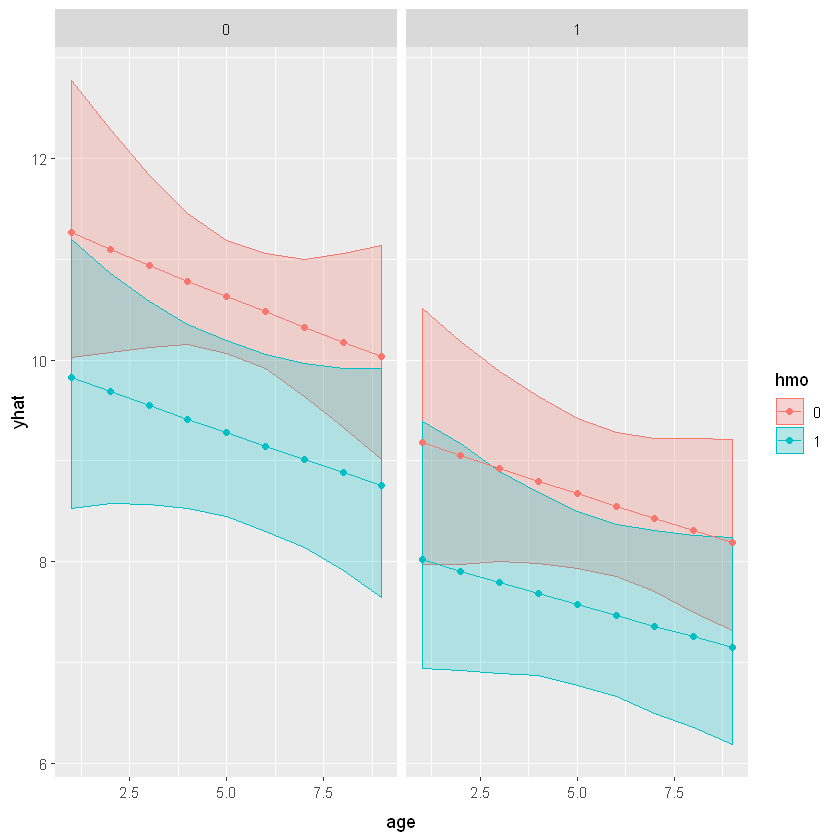

In [15]:
## function to return predicted values
fpred <- function(data, i, newdata) {
  require(VGAM)
  m <- vglm(formula = stay ~ age + hmo + died, family = pospoisson(),
    data = data[i, ], coefstart = c(2.436, -0.014, -0.136, -0.204))
  predict(m, newdata, type = "response")  }

## set seed and run bootstrap with 1,200 draws
set.seed(10)
respred <- boot(dat, fpred, R = 1200, newdata = newdata, parallel = "snow", ncpus = 4)

## get the bootstrapped percentile CIs
yhat <- t(sapply(1:nrow(newdata), function(i) {
    out <- boot.ci(respred, index = i, type = c("perc"))
           with(out, c(Est = t0, pLL = percent[4], pUL = percent[5]))  }))

## merge CIs with predicted values
newdata <- cbind(newdata, yhat)

## graph with CIs
ggplot(newdata, aes(x = age, y = yhat, colour = hmo, fill = hmo))  +
  geom_ribbon(aes(ymin = pLL, ymax = pUL), alpha = .25) + geom_point() + geom_line() + facet_wrap(~ died)

### Things to consider